In [5]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

In [6]:
# Part 1: Wrangling
# Problem 1
team_year_total_salary_query = "SELECT yearID, teamID, SUM(salary) as totalPayroll FROM SALARIES GROUP BY yearID, teamID"
team_year_win_per_query = "SELECT yearID, teamID, (CAST(W as float))/(CAST(G as float))*100 as winPercentage FROM TEAMS"

part1_query = "SELECT a.teamID, b.yearID, totalPayroll, winPercentage FROM (" + team_year_total_salary_query + ") a JOIN (" + team_year_win_per_query + ") b ON a.teamID = b.teamID AND a.yearID = b.yearID"
part1 = pd.read_sql(part1_query, conn)

part1

,teamID,yearID,totalPayroll,winPercentage
0,ATL,1985,14807000.0,40.740741
1,BAL,1985,11560712.0,51.552795
2,BOS,1985,10897560.0,49.693252
3,CAL,1985,14427894.0,55.555556
4,CHA,1985,9846178.0,52.147239
...,...,...,...,...
853,SLN,2014,120693000.0,55.555556
854,TBA,2014,72689100.0,47.530864
855,TEX,2014,112255059.0,41.358025
856,TOR,2014,109920100.0,51.234568


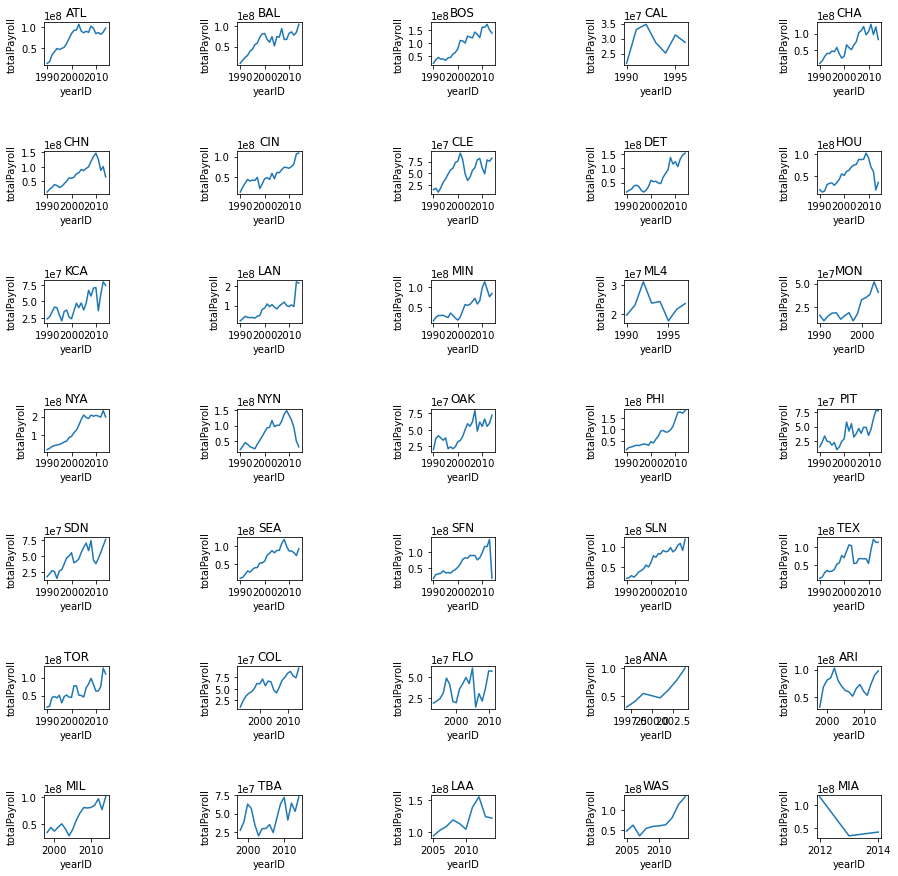

In [7]:
# Part 2: Exploratory Data Analysis
# Problem 2:

filtered_data = part1[['teamID', 'yearID', 'totalPayroll', 'winPercentage']][(part1['yearID'] >= 1990) & (part1['yearID'] <= 2014)]
teams = list(dict.fromkeys(filtered_data['teamID'].to_list()))

fig, axes = plt.subplots(nrows=7, ncols=5)

for row_counter in range(0, 7):
    for col_counter in range(0, 5):
        team_num = (row_counter * 5) + (col_counter)
        filtered_data[['yearID', 'totalPayroll']][filtered_data['teamID'] == teams[team_num]].plot(x='yearID', y='totalPayroll', legend=False, title=teams[team_num], ax=axes[row_counter, col_counter]).set_ylabel('totalPayroll')
        
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=2)
fig.subplots_adjust(hspace=2)
plt.show()

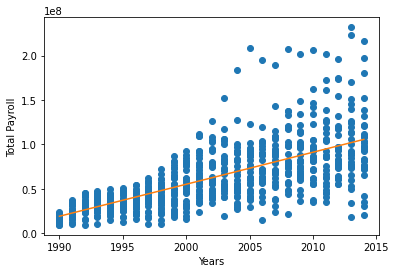

In [8]:
yearIDs_line_vals = filtered_data['yearID']
payroll_line_vals = filtered_data['totalPayroll']
m, b = np.polyfit(yearIDs_line_vals, payroll_line_vals, 1)
plt.plot(yearIDs_line_vals, payroll_line_vals, 'o')
plt.plot(yearIDs_line_vals, m*yearIDs_line_vals + b)
plt.xlabel('Years')
plt.ylabel('Total Payroll')
plt.show()

In [9]:
# Question 1:
# From the graphs in Problem 2, we can see that as time increases, so does the amount spent for payroll for most
# of the teams. There are a few teams who do have decreasing payroll totals, but it looks like for most of them,
# the trend is to increase. In the last graph, we can see that the line of best fit for the data is increasing.

# If we look further and calculate the mean and median to examine it's central tendency, we get the 
# following results:
# The mean and median of the total payroll for each year increased as time increased. This can be seen by the
# Payroll Mean vs Year scatter plot with it's correlation table and the Payroll Median vs Year scatter plot
# and it's correlation table. In both cases, the correlation ebtween year and Payroll mean/median is close to 1.

,payrollMean,std,yearID
payrollMean,1.000000,0.983600,0.991129
std,0.983600,1.000000,0.981577
yearID,0.991129,0.981577,1.000000


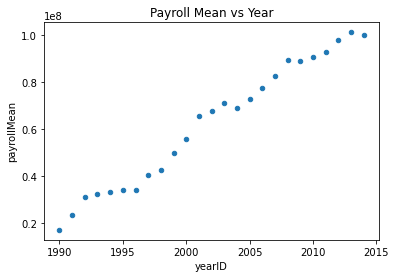

In [10]:
# Problem 3: 
#yearPayrollMean = pd.DataFrame(filtered_data.groupby('yearID')['totalPayroll'].mean())
yearPayrollMean = pd.DataFrame(filtered_data.groupby('yearID')['totalPayroll'].agg([np.mean, np.std]))
yearPayrollMean['yearID'] = yearPayrollMean.index
yearPayrollMean.columns = ['payrollMean', 'std', 'yearID']
yearPayrollMean.plot.scatter(x='yearID', y='payrollMean', title="Payroll Mean vs Year")
yearPayrollMean.corr()

,payrollMedian,yearID
payrollMedian,1.000000,0.985139
yearID,0.985139,1.000000


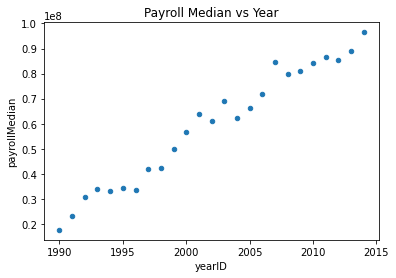

In [11]:
yearPayrollMedian = pd.DataFrame(filtered_data.groupby('yearID')['totalPayroll'].median())
yearPayrollMedian['yearID'] = yearPayrollMedian.index
yearPayrollMedian.columns = ['payrollMedian', 'yearID']
yearPayrollMedian.plot.scatter(x='yearID', y='payrollMedian', title='Payroll Median vs Year')
yearPayrollMedian.corr()

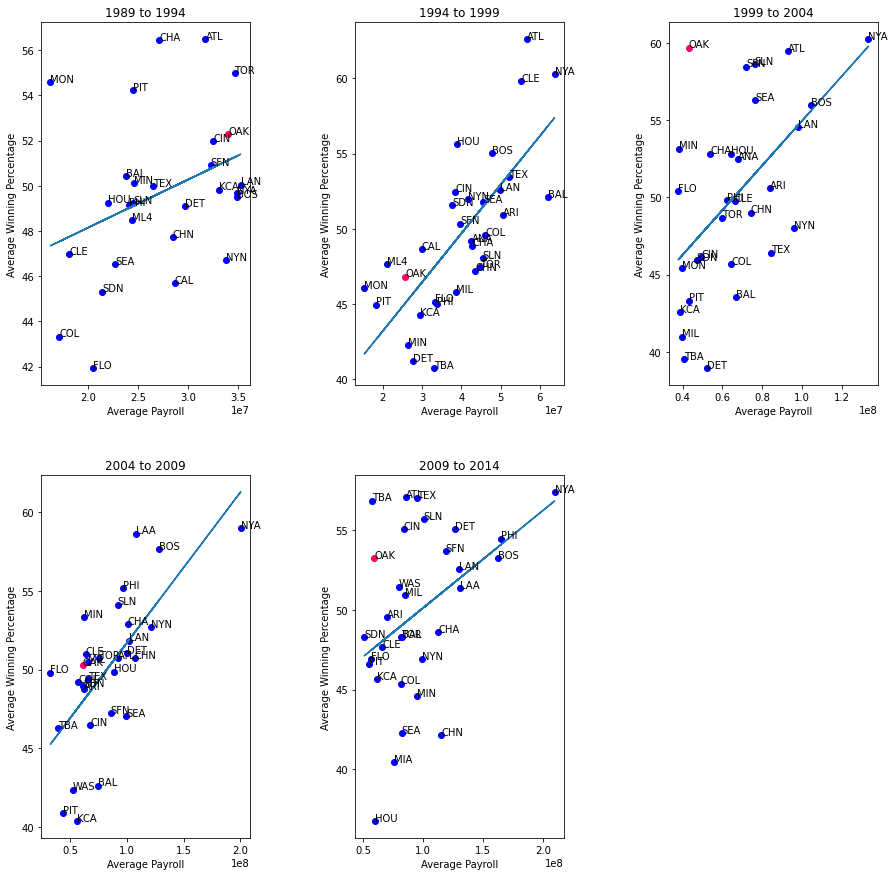

In [12]:
# Problem 4:
cats, bins = pd.cut(filtered_data['yearID'], 5, retbins=True)

fig, axes = plt.subplots(nrows=2, ncols=3)
axes_list = [axes[0][0], axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]]
axes_counter = 0

for period in range(len(bins) - 1):
    cat_payroll_mean = pd.DataFrame(filtered_data[(filtered_data['yearID'] >= bins[period]) & (filtered_data['yearID'] < bins[period + 1])].groupby('teamID')['totalPayroll'].mean())
    cat_payroll_mean['teamID'] = cat_payroll_mean.index
    cat_payroll_mean.columns = ['payrollMean', 'teamID']
    
    cat_win_mean = pd.DataFrame(filtered_data[(filtered_data['yearID'] >= bins[period]) & (filtered_data['yearID'] < bins[period + 1])].groupby('teamID')['winPercentage'].mean())
    cat_win_mean['teamID'] = cat_win_mean.index
    cat_win_mean.columns = ['winPercentageMean', 'teamID']
    
    m, b = np.polyfit(cat_payroll_mean['payrollMean'], cat_win_mean['winPercentageMean'], 1)
    axes_list[axes_counter].set_ylabel('Average Winning Percentage')
    axes_list[axes_counter].set_xlabel('Average Payroll')
    
    for i in range(len(cat_payroll_mean['payrollMean'])):
        if cat_payroll_mean['teamID'][i] == 'OAK':
            curr_color = "#FF0066"
        else:
            curr_color = "#0000FF"
        axes_list[axes_counter].scatter(cat_payroll_mean['payrollMean'][i], cat_win_mean['winPercentageMean'][i], color=curr_color)
        
    axes_list[axes_counter].plot(cat_payroll_mean['payrollMean'], m*cat_payroll_mean['payrollMean'] + b)
    axes_list[axes_counter].set_title(str(int(bins[period])) + " to " + str(int(bins[period + 1])))
    
    for i, txt in enumerate(cat_payroll_mean['teamID']):
        axes_list[axes_counter].annotate(txt, (cat_payroll_mean['payrollMean'][i], cat_win_mean['winPercentageMean'][i]))
    
    axes_counter+=1
    
fig.delaxes(axes[1][2])
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=.5)
fig.subplots_adjust(hspace=.25)
plt.show()

In [13]:
# Questions 2:
# NYA appears to be the most consistent about paying more and having a higher winning percentage. In 4 out of the 5
# time periods, they are on the top right corner of the graph. In general the trend of paying more to have a higher
# win percentage is backed up by seperating the data into 5 time periods and drawing a regrassion line through the
# mean payroll total and mean win percentages of each time. 

# If we color the OAK point red, we can see that the team started off pretty much the same as the rest of the teams
# for the first time period. In the second time period, it did spend less than most teams, but still did not
# have any significant difference in winning percentage. In the 3rd time period and 5th time period, OAK did see
# a jump in win performance compared to the other times, while spending less than most teams. In the 4th time period
# OAK was once again right in the middle of the average winning percentage vs payroll cost.

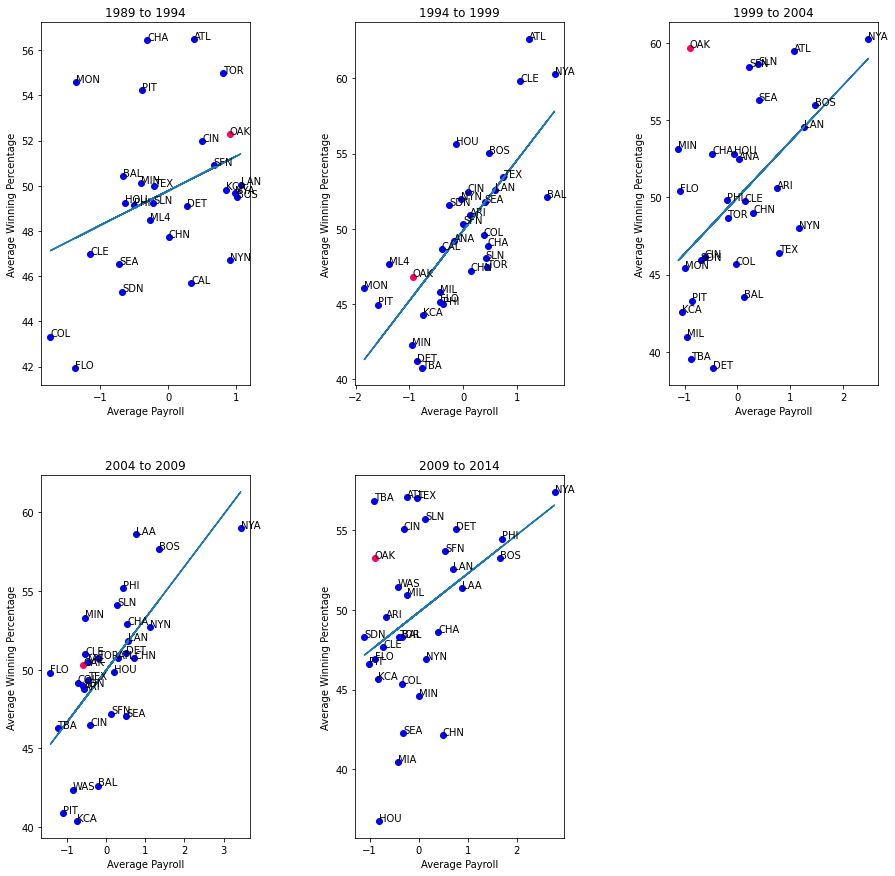

In [14]:
# Part 3: Data Transformation
# Problem 5:

year_indices = yearPayrollMean.index.values

def calc_stand_payroll(row):
    year_index = np.where(year_indices == row['yearID'])[0][0]
    avg_payroll = yearPayrollMean.iloc[year_index][0]
    s = yearPayrollMean.iloc[year_index][1]
    return (row['totalPayroll'] - avg_payroll) / (s)

filtered_data['standardizedPayroll'] = filtered_data.apply(lambda row: calc_stand_payroll(row), axis=1)

cats, bins = pd.cut(filtered_data['yearID'], 5, retbins=True)

fig, axes = plt.subplots(nrows=2, ncols=3)
axes_list = [axes[0][0], axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]]
axes_counter = 0

for period in range(len(bins) - 1):
    cat_payroll_mean = pd.DataFrame(filtered_data[(filtered_data['yearID'] >= bins[period]) & (filtered_data['yearID'] < bins[period + 1])].groupby('teamID')['standardizedPayroll'].mean())
    cat_payroll_mean['teamID'] = cat_payroll_mean.index
    cat_payroll_mean.columns = ['standardizedPayroll', 'teamID']
    
    cat_win_mean = pd.DataFrame(filtered_data[(filtered_data['yearID'] >= bins[period]) & (filtered_data['yearID'] < bins[period + 1])].groupby('teamID')['winPercentage'].mean())
    cat_win_mean['teamID'] = cat_win_mean.index
    cat_win_mean.columns = ['winPercentageMean', 'teamID']
    
    m, b = np.polyfit(cat_payroll_mean['standardizedPayroll'], cat_win_mean['winPercentageMean'], 1)
    
    for i in range(len(cat_payroll_mean['standardizedPayroll'])):
        if cat_payroll_mean['teamID'][i] == 'OAK':
            curr_color = "#FF0066"
        else:
            curr_color = "#0000FF"
        axes_list[axes_counter].scatter(cat_payroll_mean['standardizedPayroll'][i], cat_win_mean['winPercentageMean'][i], color=curr_color)
        
    axes_list[axes_counter].plot(cat_payroll_mean['standardizedPayroll'], m*cat_payroll_mean['standardizedPayroll'] + b)
    axes_list[axes_counter].set_title(str(int(bins[period])) + " to " + str(int(bins[period + 1])))
    axes_list[axes_counter].set_xlabel('Average Payroll')
    axes_list[axes_counter].set_ylabel('Average Winning Percentage')
    
    for i, txt in enumerate(cat_payroll_mean['teamID']):
        axes_list[axes_counter].annotate(txt, (cat_payroll_mean['standardizedPayroll'][i], cat_win_mean['winPercentageMean'][i]))
    
    axes_counter+=1
    
fig.delaxes(axes[1][2])
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=.5)
fig.subplots_adjust(hspace=.25)

plt.show()

In [35]:
# Question 3:
# These new graphs represent the transformation because we can see how each team is relative to other teams in the
# data. If the team's point is graphed at 0, then it is in the mean of the data. But if the team's point is graphed
# to the right of the 0, then it is 1 std or 2 std above the average. If the team's point is graphed to the left
# of the 0, then it is 1 std or 2 std below the average. Using this new standardized payroll value makes the data


# easier to understand, since the graphs have similar labes for their axis. 








yearID
1990    26
1991    26
1992    26
1993    28
1994    28
1995    28
1996    28
1997    28
1998    30
1999    30
2000    30
2001    30
2002    30
2003    30
2004    30
2005    30
2006    30
2007    30
2008    30
2009    30
2010    30
2011    30
2012    30
2013    30
2014    30
Name: totalPayroll, dtype: int64

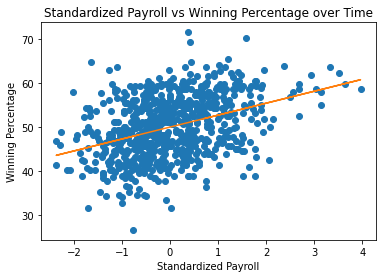

In [16]:
# Problem 7:
stand_payroll = filtered_data['standardizedPayroll']
winning_perc = filtered_data['winPercentage']
m, b = np.polyfit(stand_payroll, winning_perc, 1)
plt.plot(stand_payroll, winning_perc, 'o')
plt.plot(stand_payroll, m*stand_payroll + b)

plt.title('Standardized Payroll vs Winning Percentage over Time')
plt.xlabel('Standardized Payroll')
plt.ylabel('Winning Percentage')
plt.show()

In [17]:
def expected_win_pct(row):
    return 50 + 2.5 * row['standardizedPayroll']

filtered_data['expectedWinPct'] = filtered_data.apply(lambda row: expected_win_pct(row), axis=1)

filtered_data

,teamID,yearID,totalPayroll,winPercentage,standardizedPayroll,expectedWinPct
130,ATL,1990,14555501.0,40.123457,-0.667275,48.331811
131,BAL,1990,9680084.0,47.204969,-1.959861,45.100348
132,BOS,1990,20558333.0,54.320988,0.924213,52.310533
133,CAL,1990,21720000.0,49.382716,1.232198,53.080495
134,CHA,1990,9491500.0,58.024691,-2.009859,44.975353
...,...,...,...,...,...,...
853,SLN,2014,120693000.0,55.555556,0.457126,51.142816
854,TBA,2014,72689100.0,47.530864,-0.593171,48.517072
855,TEX,2014,112255059.0,41.358025,0.272509,50.681273
856,TOR,2014,109920100.0,51.234568,0.221422,50.553554


In [18]:
# Problem 8:

def efficiency(row):
    return row['winPercentage'] - row['expectedWinPct']

filtered_data['efficiency'] = filtered_data.apply(lambda row: efficiency(row), axis=1)

filtered_data

,teamID,yearID,totalPayroll,winPercentage,standardizedPayroll,expectedWinPct,efficiency
130,ATL,1990,14555501.0,40.123457,-0.667275,48.331811,-8.208354
131,BAL,1990,9680084.0,47.204969,-1.959861,45.100348,2.104621
132,BOS,1990,20558333.0,54.320988,0.924213,52.310533,2.010454
133,CAL,1990,21720000.0,49.382716,1.232198,53.080495,-3.697779
134,CHA,1990,9491500.0,58.024691,-2.009859,44.975353,13.049338
...,...,...,...,...,...,...,...
853,SLN,2014,120693000.0,55.555556,0.457126,51.142816,4.412740
854,TBA,2014,72689100.0,47.530864,-0.593171,48.517072,-0.986208
855,TEX,2014,112255059.0,41.358025,0.272509,50.681273,-9.323248
856,TOR,2014,109920100.0,51.234568,0.221422,50.553554,0.681014


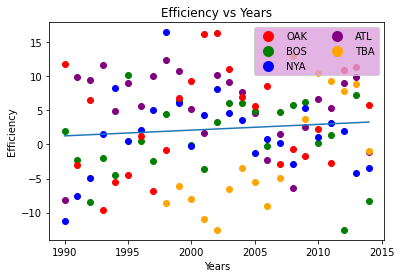

In [19]:
yearsx = filtered_data[filtered_data['teamID'].isin(['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])]['yearID']
years = filtered_data[filtered_data['teamID'].isin(['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])]['yearID']
years = years.reset_index().drop(['index'], axis=1)['yearID'].values

winning_effx = filtered_data[filtered_data['teamID'].isin(['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])]['efficiency']
winning_eff = filtered_data[filtered_data['teamID'].isin(['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])]['efficiency']
winning_eff = winning_eff.reset_index().drop(['index'], axis=1)['efficiency'].values

team_ids = filtered_data[filtered_data['teamID'].isin(['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])]['teamID']
team_ids = team_ids.reset_index().drop(['index'], axis=1)['teamID'].values

m, b = np.polyfit(yearsx, winning_effx, 1)
plt.plot(years, m*years + b)

col = {
    'OAK': 'red', 
    'BOS': 'green', 
    'NYA': 'blue', 
    'ATL': 'purple', 
    'TBA': 'orange'
}

for i in range(len(team_ids)):
        plt.scatter(years[i], winning_eff[i], color=col[team_ids[i]])
        
colors = ['red', 'green', 'blue', 'purple', 'orange']
texts = ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']
patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(handles=patches,  loc='upper right', ncol=2, facecolor="plum")

plt.title('Efficiency vs Years')
plt.xlabel('Years')
plt.ylabel('Efficiency')

plt.show()

In [20]:
# Question 4:
# From the plot in problem 8, we learn that Oakland A's were more efficient in their spending compared to other teams.
# Their winning effectiveness trended upward from 1990 to 2005. During the Moneyball period, they were at their 
# highest, this means that compared to how much they were spending, compared to other teams, they were winning much
# more.